In [2]:
from PCSampler import PCSampler, vis_pc, transform_cloud
from manifpy import SE3, SO3, SE3Tangent
import open3d as o3d
import numpy as np
import tf
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

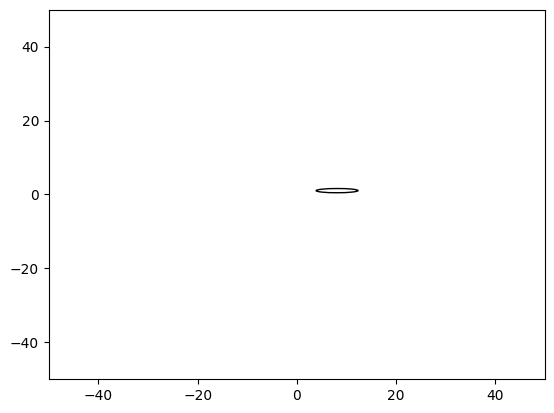

In [24]:

import pickle
from turtle import width
samples = None
with open("tf_samples.p", "rb") as f:
    samples = pickle.load(f)

iterations = 100
def calc_mean_cov(tf_list):
    mean = np.zeros(6)
    cov = np.zeros((6,6))
    for T in tf_list: 
        q = tf.transformations.quaternion_from_matrix(T)
        t = T[:3, 3]
        tf_b = SE3(np.concatenate((t, q)))
        tf_l = tf_b.log().coeffs()
        mean += tf_l
        cov += np.outer(tf_l, tf_l)
    mean = mean / iterations
    cov = cov / (iterations - 1)
    return mean, cov

mean, cov = calc_mean_cov(samples)

def ellipse_params(covmat2x2):
    a = covmat2x2[0,0]
    b = covmat2x2[0,1]
    c = covmat2x2[1,1]
    width  = (a+c)/2 + np.sqrt(((a-c)/2)**2 + b**2)
    length = (a+c)/2 - np.sqrt(((a-c)/2)**2 + b**2)
    angle = 0
    if b == 0 and a >= c:
        angle = 0
    elif b == 0 and a < c:
        angle = np.pi / 2
    else:
        angle = np.arctan2(width - a, b)
    return np.sqrt(width), np.sqrt(length), angle

w, l, a = ellipse_params(cov[:2, :2])
fig, ax = plt.subplots()
e = Ellipse(mean[:2], w, l, angle=a)
e.set_fill(False)
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
ax.add_artist(e)
ax.autoscale()
